
## Overview

This notebook implements a MobileNet-based model for hyperspectral image classification using PyTorch. The initial setup includes importing libraries, setting up directories for outputs and figures, configuring device usage (CPU or GPU), and preparing the random seed to ensure reproducibility.

Sections in this notebook:

- **Imports**: Standard libraries for file management and time, numerical computing (NumPy), plotting (matplotlib), deep learning (PyTorch), and evaluation metrics (scikit-learn) are imported.
- **Directory Setup**: Paths for saving artifacts, figures, and model runs are configured and created if they do not exist, ensuring all outputs are well-organized.
- **Device Selection**: The code automatically selects GPU (CUDA) if available for faster computations; otherwise, it defaults to the CPU.
- **Random Seed**: Fixed seeds for both NumPy and PyTorch guarantee consistent model training and data splitting results across runs.

This structured environment establishes a robust foundation for reproducible research and efficient model development and analysis.





In [1]:
# import standard libs for files and time
from pathlib import Path                                                 # work with file paths
import time                                                              # measure run time

                                                                         # import numpy and plotting
import numpy as np                                                       # handle arrays
import matplotlib.pyplot as plt                                          # make plots

                                                                         # import torch core and helpers
import torch                                                             # main deep learning lib
import torch.nn as nn                                                    # layers and losses
import torch.optim as optim                                              # optimizers
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler  # dataset and loaders

                                                                         # import metrics from sklearn
from sklearn.metrics import (                                            # classic classification metrics
    confusion_matrix,                                                    # confusion matrix
    accuracy_score,                                                      # accuracy
    precision_recall_fscore_support,                                     # precision recall f1
    cohen_kappa_score,                                                   # kappa
    classification_report,                                               # per class report text
)

                                                                         # set seeds for repeat results
np.random.seed(42)                                                       # fix numpy seed
torch.manual_seed(42)                                                    # fix torch seed

                                                                         # set folders for artifacts figures and runs
ARTIFACTS = Path("outputs/artifacts_ip")                                 # folder with saved arrays from data notebook
FIGS = Path("outputs/figs")                                              # folder for plots
RUNS = Path("outputs/runs_mobilenet2d")                                  # folder for model files and logs

                                                                         # make the folders if they are missing
FIGS.mkdir(parents=True, exist_ok=True)                                  # create figs folder
RUNS.mkdir(parents=True, exist_ok=True)                                  # create runs folder

                                                                         # pick device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")    # use cuda if available
print("Device", DEVICE)                                                  # show device

Device cuda


In [2]:
# load arrays that you saved in the first notebook
cube = np.load(ARTIFACTS / "cube_clean_norm.npy")           # H by W by B cube with z score bands
labels = np.load(ARTIFACTS / "labels.npy")                  # H by W label map with one based ids and zero for background
mask_train = np.load(ARTIFACTS / "mask_train.npy")          # H by W boolean mask for train pixels
mask_val   = np.load(ARTIFACTS / "mask_val.npy")            # H by W boolean mask for val pixels
mask_test  = np.load(ARTIFACTS / "mask_test.npy")           # H by W boolean mask for test pixels

                                                            # get sizes
H, W, B = cube.shape                                        # height width and band count
num_classes = int(labels.max())                             # number of foreground classes
print("Cube", cube.shape, "Classes", num_classes)           # print a quick summary

Cube (145, 145, 200) Classes 16


In [3]:
# this dataset returns a spatial patch around each labeled pixel
# X has shape C by P by P where C equals B
# y is a zero based class id
class PatchDataset2D(Dataset):                                                       # define a custom dataset
    def __init__(self, cube_c_last: np.ndarray, lab_map: np.ndarray,                 # init with cube labels and a mask
                 mask_map: np.ndarray, patch: int):
        assert patch % 2 == 1, "patch must be odd"                                   # require odd patch size
        self.patch = patch                                                           # store patch size
        self.rad = patch // 2                                                        # store radius
        self.H, self.W, self.C = cube_c_last.shape                                   # store sizes

# pad the image so we can cut patches near borders
        self.img = np.pad(                                                       
            cube_c_last.astype(np.float32),                                          # float array for torch
            ((self.rad, self.rad), (self.rad, self.rad), (0, 0)),                    # pad height and width
            mode="reflect"                                                           # reflect to avoid artifacts
        )

# collect pixel centers that have labels and are in the mask
        yy, xx = np.where(mask_map & (lab_map > 0))                                  # row and col for valid pixels
        self.centers = np.stack([yy, xx], axis=1)                                    # stack as N by 2 array
        self.labels = lab_map[mask_map & (lab_map > 0)].astype(np.int64) - 1         # zero base the class ids

    def __len__(self):                                                           
        return self.centers.shape[0]                                                 # number of samples

    def __getitem__(self, i):                                                        # fetch one sample
        y, x = self.centers[i]                                                       # center row and col
        yp, xp = y + self.rad, x + self.rad                                          # shift into padded image
        patch = self.img[yp - self.rad: yp + self.rad + 1,                           # slice P by P window
                         xp - self.rad: xp + self.rad + 1, :]                        # include all channels
        patch = np.transpose(patch, (2, 0, 1))                                       # change to C by P by P
        x_t = torch.from_numpy(patch)                                                # convert to tensor
        y_t = torch.tensor(self.labels[i], dtype=torch.long)                         # label tensor
        return x_t, y_t                                                              # return one pair

# set patch size
PATCH = 15                                                                           # default patch size

# build datasets for each split
ds_train = PatchDataset2D(cube, labels, mask_train, patch=PATCH)                     # train dataset
ds_val   = PatchDataset2D(cube, labels, mask_val,   patch=PATCH)                     # val dataset
ds_test  = PatchDataset2D(cube, labels, mask_test,  patch=PATCH)                     # test dataset

print("Train", len(ds_train), "Val", len(ds_val), "Test", len(ds_test), "Bands", B)  # quick info

Train 7686 Val 513 Test 2050 Bands 200


In [4]:
# we use a weighted sampler so rare classes appear more in train batches
BATCH = 64                                                                                          # batch size for train and eval

# compute per class counts on train
y_tr = ds_train.labels                                                                              # array of zero based classes
counts = np.bincount(y_tr, minlength=num_classes).astype(np.float32)                                # count samples per class
class_w = 1.0 / np.maximum(counts, 1.0)                                                             # inverse frequency per class
sample_w = class_w[y_tr]                                                                            # weight for each sample

# make weighted sampler for the train set
sampler = WeightedRandomSampler(                                                   
    weights=torch.from_numpy(sample_w),                                                             # sample weights tensor
    num_samples=len(sample_w),                                                                      # draw that many per epoch
    replacement=True,                                                                               # sample with replacement
)

# create loaders
dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, drop_last=False, num_workers=0)  # train loader
dl_val   = DataLoader(ds_val,   batch_size=BATCH, shuffle=False, drop_last=False, num_workers=0)    # val loader
dl_test  = DataLoader(ds_test,  batch_size=BATCH, shuffle=False, drop_last=False, num_workers=0)    # test loader

print("Batches  train", len(dl_train), "val", len(dl_val), "test", len(dl_test))                    # show batch counts

Batches  train 121 val 9 test 33


In [5]:
# depthwise separable conv splits spatial and channel mixing
# depthwise does a 3 by 3 per channel
# pointwise does a one by one across channels
class DWConv(nn.Module):                                                            # define a depthwise separable block
    def __init__(self, in_ch: int, out_ch: int, stride: int = 1):                   # init with input output and stride
        super().__init__()                                                          # call parent init
        self.dw = nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=stride,             # depthwise spatial conv
                            padding=1, groups=in_ch, bias=False)                   
        self.bn1 = nn.BatchNorm2d(in_ch)                                            # batch norm after depthwise
        self.pw = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)               # pointwise channel mix
        self.bn2 = nn.BatchNorm2d(out_ch)                                           # batch norm after pointwise
        self.act = nn.ReLU(inplace=True)                                            # nonlinearity

    def forward(self, x):                                                          
        x = self.dw(x)                                                              # apply depthwise conv
        x = self.bn1(x)                                                             # norm
        x = self.act(x)                                                             # relu
        x = self.pw(x)                                                              # apply pointwise conv
        x = self.bn2(x)                                                             # norm
        x = self.act(x)                                                             # relu
        return x                                                                    # return features

# a small MobileNet style net for patches
class MobileNet2D(nn.Module):                                                       # define the full model
    def __init__(self, in_ch: int, num_classes: int, reduce_to: int | None = 32):   # init with input channels and classes
        super().__init__()                                                          # parent init
        c_in = in_ch                                                                # current channel count

# optional reducer to handle many bands
        if reduce_to is not None:                                                   # if we want to reduce bands
            self.reduce = nn.Sequential(
                nn.Conv2d(c_in, reduce_to, kernel_size=1, bias=False),              # one by one conv to cut channels
                nn.BatchNorm2d(reduce_to),                                          # norm
                nn.ReLU(inplace=True),                                              # relu
            )
            c_in = reduce_to                                                        # update channel count
        else:
            self.reduce = nn.Identity()                                             # do nothing if reducer is off

# stem to get first features
        self.stem = nn.Sequential(
            nn.Conv2d(c_in, 32, kernel_size=3, stride=1, padding=1, bias=False),    # first 3 by 3 conv
            nn.BatchNorm2d(32),                                                     # norm
            nn.ReLU(inplace=True),                                                  # relu
        )

# depthwise stages with downsampling by max pool
        self.stage1 = nn.Sequential(
            DWConv(32, 64, stride=1),                                               # two blocks at same size
            DWConv(64, 64, stride=1),
            nn.MaxPool2d(2),                                                        # half spatial size
        )
        self.stage2 = nn.Sequential(
            DWConv(64, 96, stride=1),                                               # increase channels a bit
            DWConv(96, 96, stride=1),
            nn.MaxPool2d(2),                                                        # half size again
        )
        self.stage3 = nn.Sequential(
            DWConv(96, 128, stride=1),                                              # final features
            DWConv(128, 128, stride=1),
        )

# global average pool and classifier head
        self.pool = nn.AdaptiveAvgPool2d(1)                                         # pool to one by one
        self.head = nn.Sequential(
            nn.Flatten(),                                                           # flatten to vector
            nn.Linear(128, 256),                                                    # hidden layer
            nn.ReLU(inplace=True),                                                  # relu
            nn.Linear(256, num_classes),                                            # logits for classes
        )

    def forward(self, x):                                                          
        x = self.reduce(x)                                                          # optional channel reduce
        x = self.stem(x)                                                            # stem features
        x = self.stage1(x)                                                          # stage one
        x = self.stage2(x)                                                          # stage two
        x = self.stage3(x)                                                          # stage three
        x = self.pool(x)                                                            # global pool
        x = torch.flatten(x, 1)                                                     # flatten features
        out = self.head(x)                                                          # classifier
        return out                                                                  # return logits

# set reducer size to make it light
REDUCE = 32                                                                         # set None to keep all bands

# build the model and move to device
model = MobileNet2D(in_ch=B, num_classes=num_classes, reduce_to=REDUCE).to(DEVICE)  # create model on device
print("Params", sum(p.numel() for p in model.parameters()))                         # print parameter count

Params 109488


In [6]:
# define loss optimizer and scheduler
criterion = nn.CrossEntropyLoss()                                                      # use cross entropy loss
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-5)                # AdamW optimizer
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)                  # cosine schedule over epochs

# helper to compute metrics from logits
def metrics_from_logits(logits: torch.Tensor, targets: torch.Tensor, C: int) -> dict:  # compute metrics
    preds = logits.argmax(1).cpu().numpy()                                             # predicted ids
    true = targets.cpu().numpy()                                                       # true ids
    acc = accuracy_score(true, preds)                                                  # accuracy
    prec, rec, f1, _ = precision_recall_fscore_support(true, preds,                    # macro precision recall f1
                                                       labels=np.arange(C),
                                                       average="macro",
                                                       zero_division=0)
    kap = cohen_kappa_score(true, preds)                                               # kappa
    cm = confusion_matrix(true, preds, labels=np.arange(C))                            # confusion matrix
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "kappa": kap, "cm": cm}    # pack metrics

In [7]:
# set training length and early stop
EPOCHS = 120                                                                                             # max number of epochs
PATIENCE = 15                                                                                            # early stop patience

# track best model by macro f1
best_score = float("-inf")                                                                               # best f1 so far
best_state = None                                                                                        # best weights
best_epoch = 0                                                                                           # epoch with best f1
bad_epochs = 0                                                                                           # count epochs with no gain
history = []                                                                                             # store history rows

# measure time
t0 = time.time()                                                                                         # start timer

# main loop
for ep in range(1, EPOCHS + 1):                                                                          # loop over epochs
    model.train()                                                                                        # set train mode
    run, n = 0.0, 0                                                                                      # reset accumulators

# one pass over train loader
    for xb, yb in dl_train:                                                                              # loop over batches
        xb = xb.to(DEVICE)                                                                               # move data to device
        yb = yb.to(DEVICE)                                                                               # move labels to device
        optimizer.zero_grad(set_to_none=True)                                                            # clear grads
        lg = model(xb)                                                                                   # forward pass
        ls = criterion(lg, yb)                                                                           # compute loss
        ls.backward()                                                                                    # backprop
        optimizer.step()                                                                                 # optimizer step
        run += ls.item() * xb.size(0)                                                                    # sum loss
        n += xb.size(0)                                                                                  # sum items
    tr_loss = run / max(1, n)                                                                            # average train loss

# evaluate on val
    model.eval()                                                                                         # set eval mode
    with torch.no_grad():                                                                                # no grads
        all_lg, all_y = [], []                                                                           # holders
        for xb, yb in dl_val:                                                                            # val loop
            all_lg.append(model(xb.to(DEVICE)))                                                          # collect logits
            all_y.append(yb.to(DEVICE))                                                                  # collect labels
        lg_cat = torch.cat(all_lg, 0)                                                                    # stack logits
        y_cat  = torch.cat(all_y, 0)                                                                     # stack labels
        v_metrics = metrics_from_logits(lg_cat, y_cat, num_classes)                                      # compute metrics
    scheduler.step()                                                                                     # step scheduler

# log and print
    history.append({"epoch": ep, "train_loss": tr_loss,                                                  # save row
                    "val_acc": v_metrics["acc"], "val_f1": v_metrics["f1"]})
    print(f"Epoch {ep:03d}  tl {tr_loss:.4f}  va {v_metrics['acc']:.4f}  vf {v_metrics['f1']:.4f}")      # progress

# early stop on macro f1
    if v_metrics["f1"] > best_score:                                                                     # if better f1
        best_score = v_metrics["f1"]                                                                     # update best score
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}                # copy weights
        best_epoch = ep                                                                                  # store epoch
        bad_epochs = 0                                                                                   # reset patience counter
    else:
        bad_epochs += 1                                                                                  # add one bad epoch
        if bad_epochs >= PATIENCE:                                                                       # check patience
            print("Early stop at epoch", ep, "best epoch", best_epoch, "best F1", round(best_score, 4))  # note stop
            break                                                                                        # exit loop

# total train time
train_time = time.time() - t0                                                                            # compute seconds
print("Train time seconds", round(train_time, 2))                                                        # print time

# save best checkpoint
ckpt_path = RUNS / "mobilenet2d_fullbands_best.pth"                                                      # path to file
torch.save({"state_dict": best_state, "num_classes": num_classes,                                        # pack state and meta
            "PATCH": PATCH, "B": B, "REDUCE": REDUCE}, ckpt_path)                                        # include patch and band meta
print("Saved", ckpt_path.as_posix())                                                                     # confirm save

Epoch 001  tl 1.1586  va 0.6842  vf 0.7528
Epoch 002  tl 0.3128  va 0.9123  vf 0.9399
Epoch 003  tl 0.2006  va 0.9025  vf 0.9545
Epoch 004  tl 0.1020  va 0.9727  vf 0.9814
Epoch 005  tl 0.1008  va 0.9825  vf 0.9854
Epoch 006  tl 0.0679  va 0.9610  vf 0.9769
Epoch 007  tl 0.0654  va 0.9903  vf 0.9933
Epoch 008  tl 0.0223  va 0.9688  vf 0.9751
Epoch 009  tl 0.0754  va 0.9922  vf 0.9957
Epoch 010  tl 0.0415  va 0.9903  vf 0.9866
Epoch 011  tl 0.0587  va 0.9981  vf 0.9989
Epoch 012  tl 0.0235  va 0.9942  vf 0.9952
Epoch 013  tl 0.0145  va 0.9981  vf 0.9989
Epoch 014  tl 0.0156  va 0.9942  vf 0.9945
Epoch 015  tl 0.0112  va 0.9864  vf 0.9873
Epoch 016  tl 0.0470  va 0.9981  vf 0.9933
Epoch 017  tl 0.0430  va 1.0000  vf 1.0000
Epoch 018  tl 0.0092  va 0.9981  vf 0.9989
Epoch 019  tl 0.0211  va 0.9922  vf 0.9694
Epoch 020  tl 0.0313  va 0.9961  vf 0.9976
Epoch 021  tl 0.0252  va 0.9981  vf 0.9933
Epoch 022  tl 0.0144  va 1.0000  vf 1.0000
Epoch 023  tl 0.0095  va 1.0000  vf 1.0000
Epoch 024  

Val accuracy 1.0
Val kappa 1.0
Val f1 macro 1.0


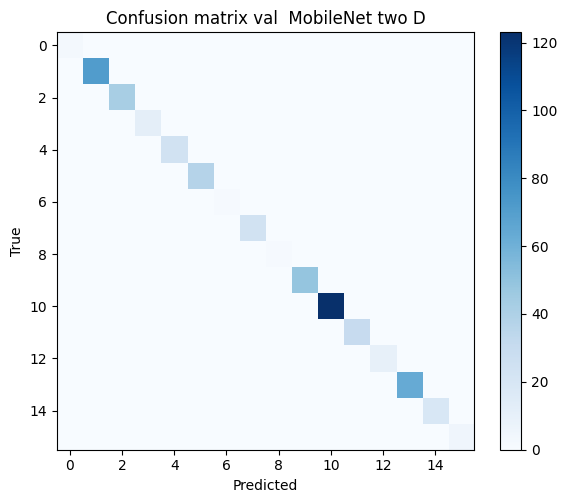

In [8]:
# load best weights and score on validation
model.load_state_dict(best_state)                               # load best weights
model.to(DEVICE).eval()                                         # set to eval

# collect logits and targets on val
with torch.no_grad():                                           # no grads
    v_logits, v_targets = [], []                                # holders
    for xb, yb in dl_val:                                       # loop val
        v_logits.append(model(xb.to(DEVICE)))                   # logits
        v_targets.append(yb.to(DEVICE))                         # labels
    v_logits = torch.cat(v_logits, 0)                           # stack logits
    v_targets = torch.cat(v_targets, 0)                         # stack labels
    vm = metrics_from_logits(v_logits, v_targets, num_classes)  # metrics

# print metrics
print("Val accuracy", vm["acc"])                                # show accuracy
print("Val kappa", vm["kappa"])                                 # show kappa
print("Val f1 macro", vm["f1"])                                 # show macro f1

# plot confusion
plt.figure(figsize=(6, 5))                                      # new figure
plt.imshow(vm["cm"], cmap="Blues")                              # show matrix
plt.title("Confusion matrix val  MobileNet two D")              # title
plt.xlabel("Predicted")                                         # x label
plt.ylabel("True")                                              # y label
plt.colorbar()                                                  # color bar
plt.tight_layout()                                              # tidy
plt.savefig(FIGS / "mobilenet2d_confusion_val.png", dpi=150)    # save figure
plt.show()                                                      # draw figure

Test accuracy 0.9980487804878049
Test kappa 0.9977757307267068
Test f1 macro 0.997351953025001


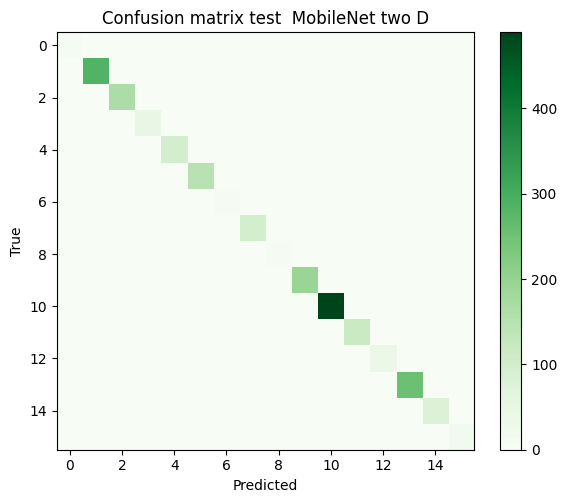


Classification report on test
              precision    recall  f1-score   support

     class_1     1.0000    1.0000    1.0000         9
     class_2     1.0000    0.9965    0.9982       286
     class_3     1.0000    1.0000    1.0000       166
     class_4     1.0000    1.0000    1.0000        47
     class_5     0.9898    1.0000    0.9949        97
     class_6     1.0000    1.0000    1.0000       146
     class_7     1.0000    1.0000    1.0000         5
     class_8     1.0000    1.0000    1.0000        96
     class_9     1.0000    1.0000    1.0000         4
    class_10     0.9949    1.0000    0.9974       194
    class_11     0.9980    0.9959    0.9969       491
    class_12     1.0000    0.9916    0.9958       119
    class_13     1.0000    1.0000    1.0000        41
    class_14     1.0000    1.0000    1.0000       253
    class_15     1.0000    1.0000    1.0000        77
    class_16     0.9500    1.0000    0.9744        19

    accuracy                         0.9980      

In [9]:
# evaluate on test set with the best weights
with torch.no_grad():                                                        # no grads
    t_logits, t_targets = [], []                                             # holders
    for xb, yb in dl_test:                                                   # loop test
        t_logits.append(model(xb.to(DEVICE)))                                # logits
        t_targets.append(yb.to(DEVICE))                                      # labels
    t_logits = torch.cat(t_logits, 0)                                        # stack logits
    t_targets = torch.cat(t_targets, 0)                                      # stack labels
    tm = metrics_from_logits(t_logits, t_targets, num_classes)               # metrics

# print main scores
print("Test accuracy", tm["acc"])                                            # show accuracy
print("Test kappa", tm["kappa"])                                             # show kappa
print("Test f1 macro", tm["f1"])                                             # show macro f1

# plot test confusion
plt.figure(figsize=(6, 5))                                                   # new figure
plt.imshow(tm["cm"], cmap="Greens")                                          # show matrix
plt.title("Confusion matrix test  MobileNet two D")                          # title
plt.xlabel("Predicted")                                                      # x label
plt.ylabel("True")                                                           # y label
plt.colorbar()                                                               # color bar
plt.tight_layout()                                                           # tidy
plt.savefig(FIGS / "mobilenet2d_confusion_test.png", dpi=150)                # save figure
plt.show()                                                                   # draw figure

# print per class report
names = [f"class_{i}" for i in range(1, num_classes + 1)]                    # class names list
print("\nClassification report on test")                                     # header
print(classification_report(t_targets.cpu().numpy(),                               
                            t_logits.argmax(1).cpu().numpy(),
                            target_names=names, digits=4, zero_division=0))  # full text report

In [10]:
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

# convert tensors to numpy
y_true = t_targets.cpu().numpy()
y_pred = t_logits.argmax(1).cpu().numpy()

# global metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

# per class metrics
prec_class, rec_class, f1_class, support_class = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)

print("Overall accuracy:", oa)
print("Cohen kappa:", kappa)
print("Macro precision:", prec_macro)
print("Macro recall:", rec_macro)
print("Macro f1:", f1_macro)
print("Weighted precision:", prec_weighted)
print("Weighted recall:", rec_weighted)
print("Weighted f1:", f1_weighted)

print("\nPer class metrics")
for i, (p, r, f1, s) in enumerate(
    zip(prec_class, rec_class, f1_class, support_class), start=1
):
    print(
        f"Class {i:02d}: "
        f"precision={p:.4f}, recall={r:.4f}, f1={f1:.4f}, support={s}"
    )

print("\nFull classification report")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=[f"class_{i}" for i in range(1, num_classes + 1)],
        digits=4,
        zero_division=0,
    )
)


Overall accuracy: 0.9980487804878049
Cohen kappa: 0.9977757307267068
Macro precision: 0.9957891810570382
Macro recall: 0.9990016759627098
Macro f1: 0.997351953025001
Weighted precision: 0.9980796543758217
Weighted recall: 0.9980487804878049
Weighted f1: 0.9980547100239301

Per class metrics
Class 01: precision=1.0000, recall=1.0000, f1=1.0000, support=9
Class 02: precision=1.0000, recall=0.9965, f1=0.9982, support=286
Class 03: precision=1.0000, recall=1.0000, f1=1.0000, support=166
Class 04: precision=1.0000, recall=1.0000, f1=1.0000, support=47
Class 05: precision=0.9898, recall=1.0000, f1=0.9949, support=97
Class 06: precision=1.0000, recall=1.0000, f1=1.0000, support=146
Class 07: precision=1.0000, recall=1.0000, f1=1.0000, support=5
Class 08: precision=1.0000, recall=1.0000, f1=1.0000, support=96
Class 09: precision=1.0000, recall=1.0000, f1=1.0000, support=4
Class 10: precision=0.9949, recall=1.0000, f1=0.9974, support=194
Class 11: precision=0.9980, recall=0.9959, f1=0.9969, sup

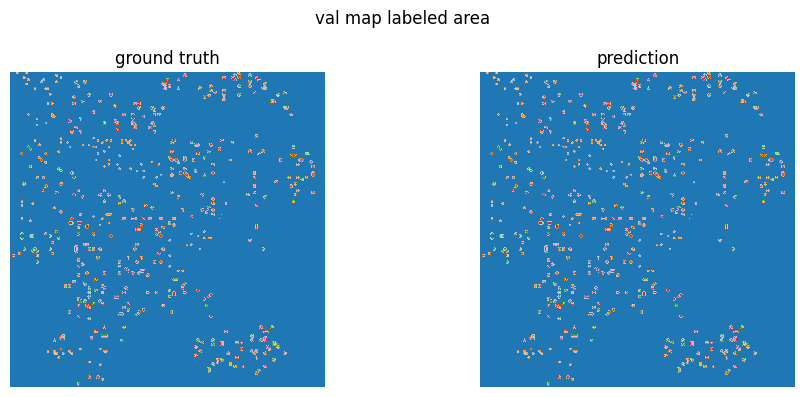

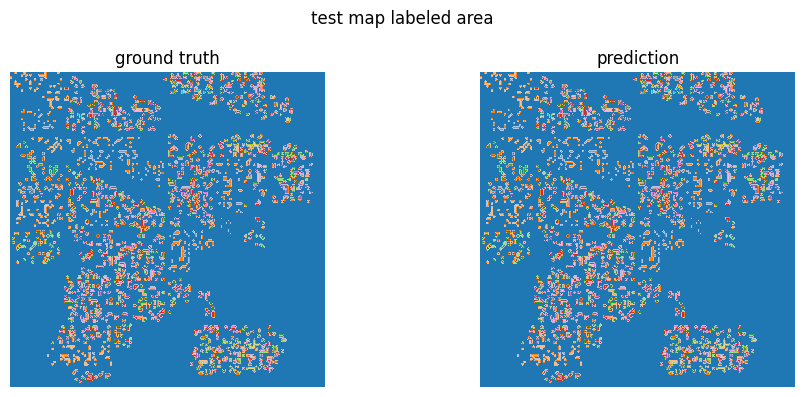

In [10]:
# predict only on labeled pixels to make quick maps
def predict_on_mask(model, ds: PatchDataset2D, mask_map: np.ndarray,                                            # function header
                    num_classes: int) -> np.ndarray:
    model.eval()                                                                                                # set eval
    pred_map = np.zeros_like(labels, dtype=np.int64)                                                            # init output map
    loader = DataLoader(ds, batch_size=256, shuffle=False)                                                      # small loader
    idx = 0                                                                                                     # running index
    with torch.no_grad():                                                                                       # no grads
        for xb, _ in loader:                                                                                    # loop over patches
            lg = model(xb.to(DEVICE))                                                                           # get logits
            pb = lg.argmax(1).cpu().numpy() + 1                                                                 # back to one based ids
            n = pb.shape[0]                                                                                     # count in batch
            for j in range(n):                                                                                  # write each center
                y, x = ds.centers[idx + j]                                                                      # get center coords
                pred_map[y, x] = pb[j]                                                                          # set prediction
            idx += n                                                                                            # move index
    pred_map[~mask_map] = 0                                                                                     # keep zeros off mask
    return pred_map                                                                                             # return map

# make val and test maps on masked areas
pred_val_map = predict_on_mask(model, ds_val, mask_val & (labels > 0), num_classes)                             # val map
pred_test_map = predict_on_mask(model, ds_test, mask_test & (labels > 0), num_classes)                          # test map

# helper to show two maps side by side
def show_maps(gt, pr, title, fname):                                                                            # function header
    plt.figure(figsize=(10, 4))                                                                                 # make figure
    plt.subplot(1, 2, 1)                                                                                        # left panel
    plt.imshow(gt, cmap="tab20")                                                                                # show ground truth
    plt.title("ground truth")                                                                                   # title left
    plt.axis("off")                                                                                             # hide axes
    plt.subplot(1, 2, 2)                                                                                        # right panel
    plt.imshow(pr, cmap="tab20")                                                                                # show predictions
    plt.title("prediction")                                                                                     # title right
    plt.axis("off")                                                                                             # hide axes
    plt.suptitle(title)                                                                                         # big title
    plt.tight_layout()                                                                                          # tidy
    plt.savefig(FIGS / fname, dpi=150)                                                                          # save figure
    plt.show()                                                                                                  # draw figure

# draw the maps
show_maps(np.where(mask_val, labels, 0), pred_val_map, "val map labeled area", "mobilenet2d_val_maps.png")      # val maps
show_maps(np.where(mask_test, labels, 0), pred_test_map, "test map labeled area", "mobilenet2d_test_maps.png")  # test maps